In [12]:
import os
import glob
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch_fidelity import calculate_metrics
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from data import ImageDataset
from data import split_dataset
from training_pipeline import worker_init_fn, set_seed
from models import Generator, Discriminator
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from serialization import save

random_seed = 42
set_seed(random_seed)

In [5]:
# enough to call just once
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

source_path = "data/cats/Data"
destination_path = "data/cats/split_data"
split_dataset(source_path, destination_path, train_ratio, val_ratio, test_ratio, random_seed)

data\cats\split_data\train
data\cats\split_data\val
data\cats\split_data\test


In [2]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), # to set (64, 64) by default
#     transforms.ToTensor()
# ])

img_size = 64

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

train_path = "data/cats/split_data/train"
val_path = "data/cats/split_data/val"
test_path = "data/cats/split_data/test"

train_dataset = ImageDataset(train_path, transform=transform)
val_dataset = ImageDataset(val_path, transform=transform)
test_dataset = ImageDataset(test_path, transform=transform)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 2048
n_workers = 4
prefetch_factor = 4 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

## DCGAN

In [3]:
latent_dim = 100
num_epochs = 1000
lr = 0.0001
beta1 = 0.5

In [4]:
netG = Generator(latent_dim).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(img_size, latent_dim, device=device)

os.makedirs("output/dcgan/fake", exist_ok=True)
os.makedirs("output/dcgan/fake_batch", exist_ok=True)

In [9]:
def eval_fid(netG, fixed_noise, fake_dir, real_dir, remove=True):
    # Save fake images - individually
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        for idx in range(fake.size(0)):
            save_image(fake[idx], f"{fake_dir}/fake_{idx}.png", normalize=True)
    
    # Compute FID
    metrics = calculate_metrics(
        input1=fake_dir,  # Generated images
        input2=real_dir,  # Real images
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True,
        verbose=False,
    )
    
    # clear fake directory
    if remove:
        for f in glob.glob(f"{fake_dir}/*"):
            os.remove(f)
    
    fid = metrics['frechet_inception_distance']
    return fid

In [6]:
G_loss_list = []
D_loss_list = []
fid_list = []

for epoch in range(num_epochs):
    G_epoch_loss = 0.0
    D_epoch_loss = 0.0

    for i, real_imgs in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        real_imgs += 0.05 * torch.randn_like(real_imgs)  # noise injection
        
        b_size = real_imgs.size(0)
        real_labels = torch.full((b_size,), 0.9, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        ## Discriminator update
        netD.zero_grad()
        output_real = netD(real_imgs)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, latent_dim, device=device)
        fake_imgs = netG(noise)
        fake_imgs = fake_imgs + 0.05 * torch.randn_like(fake_imgs).to(device)

        output_fake = netD(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        ## Generator update
        netG.zero_grad()
        output = netD(fake_imgs)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizerG.step()

        G_epoch_loss += loss_G.item()
        D_epoch_loss += loss_D.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}] Loss_D: {loss_D:.4f} Loss_G: {loss_G:.4f}")
    
    # Average losses per epoch
    G_loss_list.append(G_epoch_loss / len(train_loader))
    D_loss_list.append(D_epoch_loss / len(train_loader))

    # FID every 10 epochs
    if epoch % 10 == 0:
        fid = eval_fid(netG, fixed_noise, "output/dcgan/fake", "data/cats/split_data/val")
        fid_list.append(fid)
        print(f"Val FID: {fid}")

    # Save sample outputs
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        save_image(fake, f"output/dcgan/fake_batch/fake_epoch_{epoch+1:03d}.png", normalize=True)


Epoch [1/1000] Step [0] Loss_D: 1.3760 Loss_G: 1.5983


C:\Users\jakub\anaconda3\Lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


Val FID: 424.4761328993383
Epoch [2/1000] Step [0] Loss_D: 0.4673 Loss_G: 3.5841
Epoch [3/1000] Step [0] Loss_D: 0.3675 Loss_G: 4.4423
Epoch [4/1000] Step [0] Loss_D: 0.3839 Loss_G: 6.2826
Epoch [5/1000] Step [0] Loss_D: 0.3434 Loss_G: 5.5826
Epoch [6/1000] Step [0] Loss_D: 0.3470 Loss_G: 5.7878
Epoch [7/1000] Step [0] Loss_D: 0.6218 Loss_G: 1.7049
Epoch [8/1000] Step [0] Loss_D: 0.3821 Loss_G: 6.6178
Epoch [9/1000] Step [0] Loss_D: 0.3872 Loss_G: 6.8747
Epoch [10/1000] Step [0] Loss_D: 0.3513 Loss_G: 6.2317
Epoch [11/1000] Step [0] Loss_D: 0.3615 Loss_G: 6.2319
Val FID: 340.8891252523629
Epoch [12/1000] Step [0] Loss_D: 0.3698 Loss_G: 9.1630
Epoch [13/1000] Step [0] Loss_D: 0.3570 Loss_G: 6.6984
Epoch [14/1000] Step [0] Loss_D: 0.4390 Loss_G: 3.5371
Epoch [15/1000] Step [0] Loss_D: 0.6885 Loss_G: 3.0175
Epoch [16/1000] Step [0] Loss_D: 0.5150 Loss_G: 4.1362
Epoch [17/1000] Step [0] Loss_D: 1.0355 Loss_G: 2.6197
Epoch [18/1000] Step [0] Loss_D: 1.2173 Loss_G: 6.7160
Epoch [19/1000] Ste

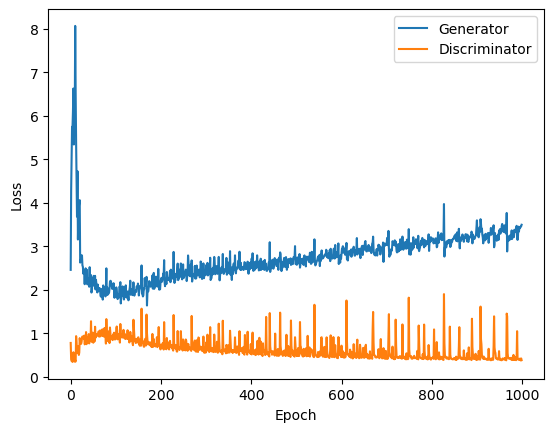

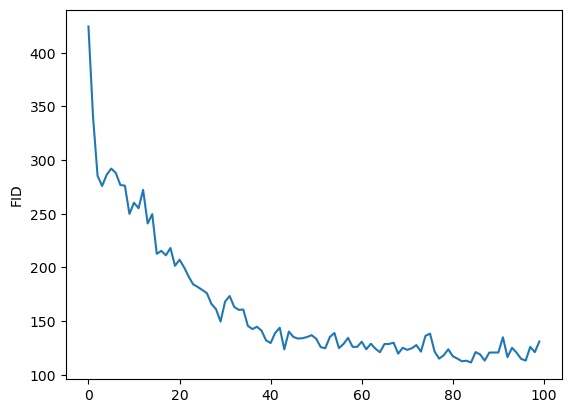

In [7]:
plt.plot(G_loss_list)
plt.plot(D_loss_list)
plt.legend(["Generator", "Discriminator"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(fid_list)
plt.ylabel("FID")
plt.show()

In [10]:
# Evaluation
fid = eval_fid(netG, fixed_noise, "output/dcgan/fake", "data/cats/split_data/test", remove=False)
print(f"Test FID: {fid}")

Test FID: 116.64841461674236


In [11]:
# save models
os.makedirs("models/dcgan", exist_ok=True)
torch.save(netG.state_dict(), "models/dcgan/netG.pth")
torch.save(netD.state_dict(), "models/dcgan/netD.pth")

In [13]:
# save results
os.makedirs("output/dcgan/history", exist_ok=True)
save(G_loss_list, "output/dcgan/history/G_loss.txt")
save(D_loss_list, "output/dcgan/history/D_loss.txt")
save(fid_list, "output/dcgan/history/fid.txt")

# Linear interpolation

In [53]:
def interpolate_images():
    z1 = torch.randn(1, latent_dim, device=device)
    z2 = torch.randn(1, latent_dim, device=device)
    
    img1 = netG(z1).detach().cpu()
    img2 = netG(z2).detach().cpu()
    
    interpolated_z = [
        (1 - alpha) * z1 + alpha * z2 for alpha in torch.linspace(0, 1, steps=10)
    ]
    interpolated_z = torch.cat(interpolated_z, dim=0)  # shape: [10, latent_dim]
    
    with torch.no_grad():
        interpolated_imgs = netG(interpolated_z).cpu()
        
    grid = make_grid(interpolated_imgs, nrow=10, normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Latent Interpolation Between Two Noise Vectors")
    plt.show()

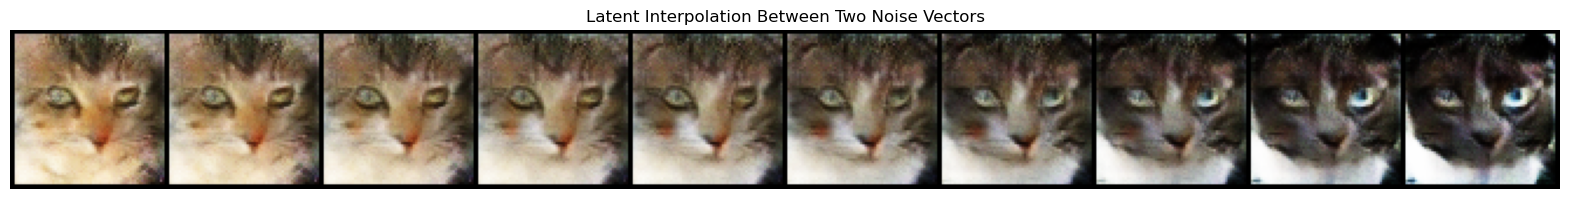

In [54]:
set_seed(0)
interpolate_images()

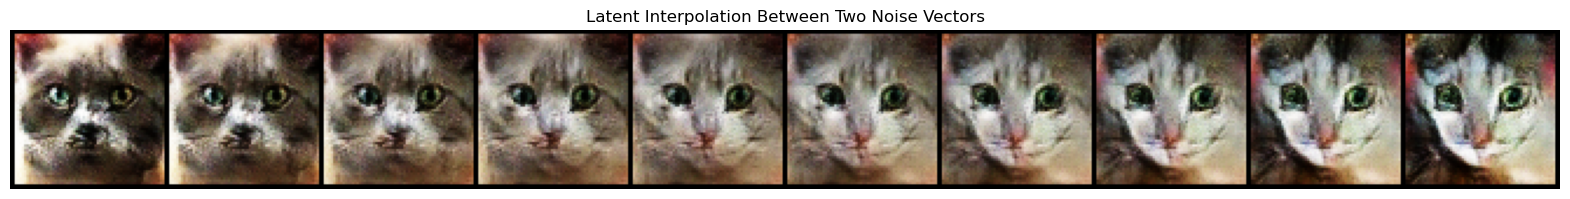

In [55]:
set_seed(6)
interpolate_images()

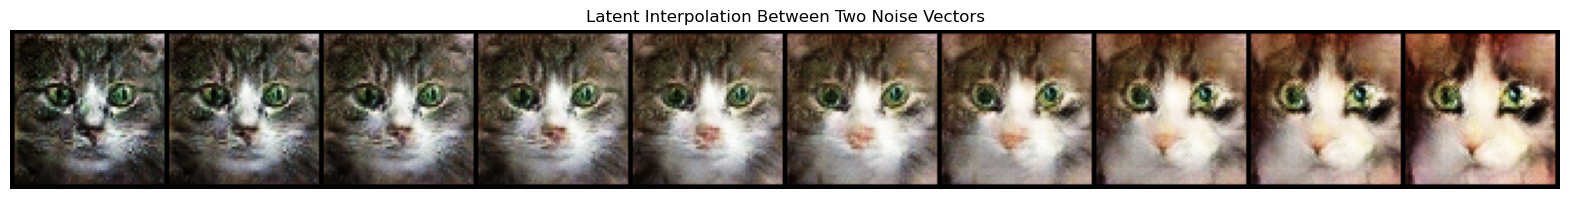

In [67]:
set_seed(16)
interpolate_images()